 # <center>     <center>Курсовой проект
    
<font size=3>  <center>
<font size=4>  <center>**Модуль: "Библиотеки Python для Data Science: Numpy, Matplotlib, Scikit-learn"**
    
    
<font size=3>  *Слушатель: Турчин М.В.*<br>
<font size=3> *Группа: 1366*<br>
<font size=3> *Факультет: "Аналитика Big Data"*<br>
    
    
    ------------------------------------------------------------------------------------------------------------------

<a id='section_id_0'></a>
### Содержание:
1. **[Подготовим исходные данные](#section_id_1)**
2. **[Получим базовое решение](#section_id_2)**
3. **[EDA](#section_id_3)**
4. **[Предобработка данных](#section_id_4)**
5. **[Обучение и валидация моделей](#section_id_5)**
6. **[Воспроизводимость](#section_id_6)**
7. **[Выводы](#section_id_7)**
7. **[ВЫВОД ИТОГОВОГО РЕЗУЛЬТАТА ТЕСТА](#section_id_8)**

### 1. Подготовим исходные данные <a id='section_id_1'></a>

* Загрузим библиотеки
* Создадим датафрейм с исходными данными <br>
 ([назад к  меню](#section_id_0))

In [1]:
# загрузим библиотеки
import pandas as pd  
import numpy as np   
import random

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


from datetime import datetime



from sklearn import linear_model, ensemble
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor 
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import KFold, GridSearchCV
from xgboost.sklearn import XGBRegressor
from lightgbm.sklearn import LGBMRegressor
from sklearn.decomposition import PCA


import xgboost as xgb
import lightgbm as lgb
import catboost as ctb


import warnings
warnings.filterwarnings('ignore')

In [2]:
plt.rcParams.update({'font.size': 10})

In [3]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)))
    
    plt.figure(figsize=(18,10))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()

In [4]:
# загрузку данных произведем из каталога /Data
TRAIN_PATH = './Data/train.csv'
TEST_PATH = './Data/test.csv'
SUBMIT_PATH = './Data/sample_submission.csv'

In [5]:
# создадим датафрейм с данными для обучения
data_df = pd.read_csv(TRAIN_PATH)
# создадим датафрейм с данными для тестирования
df_test = pd.read_csv(TEST_PATH)
# создадим датафрейм с данными для передачи в качестве ответа на kaggle
submit = pd.read_csv(SUBMIT_PATH)
data_df.head(3)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,11809,27,3.0,115.027311,NaN,10.0,4,10.0,2014,0.075424,B,B,11,3097,0,NaN,0,0,B,305018.871089
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,B,B,30,6207,1,1183.0,1,0,B,177734.553407
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,B,B,33,5261,0,240.0,3,1,B,282078.720850


### <font size=2 color=blue> Вывод п.1 "Подготовка исходных данных"     
<font size=2 color=blue>Создали датафрейм **data_df**, содержащий данные файла "train.csv"<br> 
Создали датафрейм **df_test**, содержащий данные файла "test.csv"<br> 

### 2. Получим базовое решение  <a id='section_id_2'></a>

* Минимально познакомимся с данными 
* Заполним пропуски простым методом (нулями, медиана, среднее, мода...) 
* Обучим простую модель (линейная, деревья...) 
* Посчитаем метрику качества <br>
([назад к  меню](#section_id_0))

<font size=2>
    
**Описание датасета**

- **Id** - идентификационный номер квартиры
- **DistrictId** - идентификационный номер района
- **Rooms** - количество комнат
- **Square** - площадь
- **LifeSquare** - жилая площадь
- **KitchenSquare** - площадь кухни
- **Floor** - этаж
- **HouseFloor** - количество этажей в доме
- **HouseYear** - год постройки дома
- **Ecology_1, Ecology_2, Ecology_3** - экологические показатели местности
- **Social_1, Social_2, Social_3** - социальные показатели местности
- **Healthcare_1, Helthcare_2** - показатели местности, связанные с охраной здоровья
- **Shops_1, Shops_2** - показатели, связанные с наличием магазинов, торговых центров
- **Price** - цена квартиры



In [6]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  int64  
 1   DistrictId     10000 non-null  int64  
 2   Rooms          10000 non-null  float64
 3   Square         10000 non-null  float64
 4   LifeSquare     7887 non-null   float64
 5   KitchenSquare  10000 non-null  float64
 6   Floor          10000 non-null  int64  
 7   HouseFloor     10000 non-null  float64
 8   HouseYear      10000 non-null  int64  
 9   Ecology_1      10000 non-null  float64
 10  Ecology_2      10000 non-null  object 
 11  Ecology_3      10000 non-null  object 
 12  Social_1       10000 non-null  int64  
 13  Social_2       10000 non-null  int64  
 14  Social_3       10000 non-null  int64  
 15  Healthcare_1   5202 non-null   float64
 16  Helthcare_2    10000 non-null  int64  
 17  Shops_1        10000 non-null  int64  
 18  Shops_2

In [7]:
# возьмем в рассмотрение только вещественные признаки

data_df_num = data_df.select_dtypes(include=[np.int64, np.float64])

X_test_start = df_test.select_dtypes(include=[np.int64, np.float64])
data_df_num

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
0,11809,27,3.0,115.027311,NaN,10.0,4,10.0,2014,0.075424,11,3097,0,NaN,0,0,305018.871089
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,30,6207,1,1183.0,1,0,177734.553407
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,33,5261,0,240.0,3,1,282078.720850
3,2352,1,1.0,40.409907,NaN,1.0,10,22.0,1977,0.007122,1,264,0,NaN,0,1,168106.007630
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,33,8667,2,NaN,0,6,343995.102962
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1260,61,2.0,49.090728,33.272626,6.0,3,12.0,1981,0.300323,52,10311,6,NaN,1,9,119367.455796
9996,16265,27,2.0,64.307684,37.038420,9.0,13,0.0,1977,0.072158,2,629,1,NaN,0,0,199715.148807
9997,2795,178,1.0,29.648057,16.555363,5.0,3,5.0,1958,0.460556,20,4386,14,NaN,1,5,165953.912580
9998,14561,21,1.0,32.330292,22.326870,5.0,3,9.0,1969,0.194489,47,8004,3,125.0,3,5,171842.411855


In [8]:
X_train, X_valid, y_train, y_valid = train_test_split(
    data_df_num.drop('Price', axis=1),
    data_df_num.Price, 
    test_size=0.2,
    random_state=42)

In [9]:
# Проверим наличие пропусков в обучающей выборке (аналогично на валидационной и на тестовой)
X_train.isna().sum()

Id                  0
DistrictId          0
Rooms               0
Square              0
LifeSquare       1695
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1     3878
Helthcare_2         0
Shops_1             0
dtype: int64

In [10]:
# заполним медианами из трейна пропуски на валидационной и на тестовой выборках
X_train.fillna(X_train.median(), inplace=True)
X_valid.fillna(X_train.median(), inplace=True)
X_test_start.fillna(X_train.median(), inplace=True)


In [11]:
# Убедимся, что пропуски заполнены
X_train.isna().sum()

Id               0
DistrictId       0
Rooms            0
Square           0
LifeSquare       0
KitchenSquare    0
Floor            0
HouseFloor       0
HouseYear        0
Ecology_1        0
Social_1         0
Social_2         0
Social_3         0
Healthcare_1     0
Helthcare_2      0
Shops_1          0
dtype: int64

**<center>создадим простые базовые модели для первого "пристрелочного" запуска модели и оценки точности**

In [12]:
#  создадим модель линейной регресси
LR_model = linear_model.LinearRegression()
LR_model

LinearRegression()

In [13]:
#  создадим модель случайного леса
RF_model = ensemble.RandomForestRegressor()
RF_model

RandomForestRegressor()

In [14]:
#  создадим модель GB_model
GB_model = GradientBoostingRegressor(criterion='mse',
                                     max_depth=6,
                                     min_samples_leaf=50,
                                     random_state=42,  
                                     n_estimators=1000, 
                                     max_features='sqrt', 
                                     loss='huber', 
                                     learning_rate=0.025)

In [15]:
# обучим модели
#обучим LR
LR_model.fit(X_train, y_train)
#обучим RF
RF_model.fit(X_train, y_train)
#обучим GB
GB_model.fit(X_train, y_train)

GradientBoostingRegressor(criterion='mse', learning_rate=0.025, loss='huber',
                          max_depth=6, max_features='sqrt', min_samples_leaf=50,
                          n_estimators=1000, random_state=42)

In [16]:
print(f'LR_model На трейне R2 = {round(LR_model.score(X_train, y_train),3)} на тесте = {round(LR_model.score(X_valid, y_valid),3)} ', )
print(f'RF_model На трейне R2 = {round(RF_model.score(X_train, y_train),3)} на тесте = {round(RF_model.score(X_valid, y_valid),3)} ', )
print(f'GB_model На трейне R2 = {round(GB_model.score(X_train, y_train),3)} на тесте = {round(GB_model.score(X_valid, y_valid),3)} ', )

LR_model На трейне R2 = 0.485 на тесте = 0.456 
RF_model На трейне R2 = 0.962 на тесте = 0.743 
GB_model На трейне R2 = 0.832 на тесте = 0.771 


In [17]:
# для вывода первоначального решения в КАГГЛ
submit.Price = RF_model.predict(X_test_start)
submit.to_csv('RF_model_start_version-light.csv', index=False)

In [18]:
# для вывода первоначального решения в КАГГЛ
submit.Price = GB_model.predict(X_test_start)
submit.to_csv('GB_model_start_version-light.csv', index=False)

### <font size=2 color=blue> Вывод п.2 "Получение базового (стартового) решения"   <br>  
<font size=2 color=blue>
    
<font size=2 color=blue>Получили неплохие параметры моделей: <br>
LR_model На трейне 	R2 = 0.485 на тесте = 0.456 <br>
RF_model На трейне 	R2 = 0.962 на тесте = 0.738   При отправке TEST на kaggle получен результат r2 = 0.70807<br>
GB_model На трейне 	R2 = 0.832 на тесте = 0.771   При отправке TEST на kaggle получен результат r2 = 0.73419<br><br>
       Получили быстрые предварительные данные по моделям "линейной регрессии", "случайного леса", "градиентного бустинга". Предварительные оценки с помощью метрики r2 (среднеквадратичное отклонение) показали, что наиболее высокие результаты дала модель "градиентного бустинга". <br>
    Возьем ее за основу анализа. 

### 3. EDA  <a id='section_id_3'></a>
[назад к  меню](#section_id_0))

<font size=2>
    
**Описание датасета**

- **Id** - идентификационный номер квартиры
- **DistrictId** - идентификационный номер района
- **Rooms** - количество комнат
- **Square** - площадь
- **LifeSquare** - жилая площадь
- **KitchenSquare** - площадь кухни
- **Floor** - этаж
- **HouseFloor** - количество этажей в доме
- **HouseYear** - год постройки дома
- **Ecology_1, Ecology_2, Ecology_3** - экологические показатели местности
- **Social_1, Social_2, Social_3** - социальные показатели местности
- **Healthcare_1, Helthcare_2** - показатели местности, связанные с охраной здоровья
- **Shops_1, Shops_2** - показатели, связанные с наличием магазинов, торговых центров
- **Price** - цена квартиры



In [19]:
##############################
data_df = pd.read_csv(TRAIN_PATH)

####  3.1. Изучим целевую переменную 

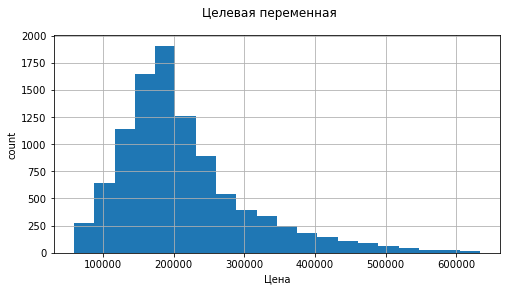

In [20]:
# 3.1. Изучим целевую переменную
plt.figure(figsize = (8, 4))
data_df['Price'].hist(density=False, bins=20)
plt.ylabel('count')
plt.xlabel('Цена')
plt.suptitle('Целевая переменная')
plt.show()

In [21]:
data_df.Price.describe()

count     10000.000000
mean     214138.857399
std       92872.293865
min       59174.778028
25%      153872.633942
50%      192269.644879
75%      249135.462171
max      633233.466570
Name: Price, dtype: float64

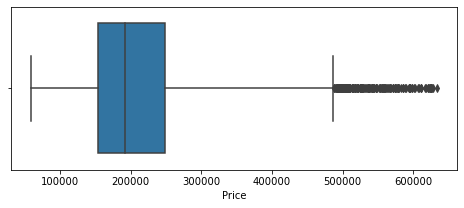

In [22]:
plt.figure(figsize=(8, 3))
sns.boxplot(data_df.Price, whis=2.5)
plt.xlabel('Price')
plt.show()

In [23]:
data_df.loc[(data_df.Price > 600000) & (data_df.Square < 90)]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
5997,15749,66,3.0,78.747853,33.885760,11.0,2,5.0,1955,0.161976,B,A,31,7010,5,4508.0,3,7,B,606958.937510
8339,1225,157,3.0,76.460332,49.979154,8.0,9,8.0,1960,0.000000,B,B,30,7538,87,4702.0,5,5,B,617749.118586
8803,13226,73,2.0,73.210349,NaN,1.0,16,17.0,2019,0.042032,B,B,37,6856,84,1940.0,2,5,B,633233.466570
9006,9840,108,3.0,78.824038,53.016323,8.0,2,8.0,1958,0.000000,B,B,23,3684,2,NaN,0,4,B,611542.063430
9826,11013,43,2.0,58.757047,34.605286,8.0,12,17.0,2004,0.000078,B,B,22,6398,141,1046.0,3,23,B,625678.644994


In [24]:
# Квартиры с площадью меньше 90 и ценой дороже 600000 можно было бы убрать из выборки
data_df.drop(data_df[(data_df['Price'] > 600000) & (data_df['Square'] < 90)].index)


,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,11809,27,3.0,115.027311,NaN,10.0,4,10.0,2014,0.075424,B,B,11,3097,0,NaN,0,0,B,305018.871089
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,B,B,30,6207,1,1183.0,1,0,B,177734.553407
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,B,B,33,5261,0,240.0,3,1,B,282078.720850
3,2352,1,1.0,40.409907,NaN,1.0,10,22.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,168106.007630
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,B,B,33,8667,2,NaN,0,6,B,343995.102962
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1260,61,2.0,49.090728,33.272626,6.0,3,12.0,1981,0.300323,B,B,52,10311,6,NaN,1,9,B,119367.455796
9996,16265,27,2.0,64.307684,37.038420,9.0,13,0.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A,199715.148807
9997,2795,178,1.0,29.648057,16.555363,5.0,3,5.0,1958,0.460556,B,B,20,4386,14,NaN,1,5,B,165953.912580
9998,14561,21,1.0,32.330292,22.326870,5.0,3,9.0,1969,0.194489,B,B,47,8004,3,125.0,3,5,B,171842.411855


#### 
<font color=blue>
    
**Вывод по 3.1.:**<BR>
Распределение целевой - нормальное. Выбросы по квартирам с площадью меньше 90 и ценой дороже 600000 можно будет удалить из выборки.

####  3.2. Изучим признаки

In [25]:
data_df.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.00000,10000.000000,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,8383.40770,50.400800,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,4859.01902,43.587592,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,0.00000,0.000000,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,4169.50000,20.000000,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,8394.50000,36.000000,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,12592.50000,75.000000,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,16798.00000,209.000000,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


##### ***3.2.1. Количественные признаки***

In [26]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  int64  
 1   DistrictId     10000 non-null  int64  
 2   Rooms          10000 non-null  float64
 3   Square         10000 non-null  float64
 4   LifeSquare     7887 non-null   float64
 5   KitchenSquare  10000 non-null  float64
 6   Floor          10000 non-null  int64  
 7   HouseFloor     10000 non-null  float64
 8   HouseYear      10000 non-null  int64  
 9   Ecology_1      10000 non-null  float64
 10  Ecology_2      10000 non-null  object 
 11  Ecology_3      10000 non-null  object 
 12  Social_1       10000 non-null  int64  
 13  Social_2       10000 non-null  int64  
 14  Social_3       10000 non-null  int64  
 15  Healthcare_1   5202 non-null   float64
 16  Helthcare_2    10000 non-null  int64  
 17  Shops_1        10000 non-null  int64  
 18  Shops_2

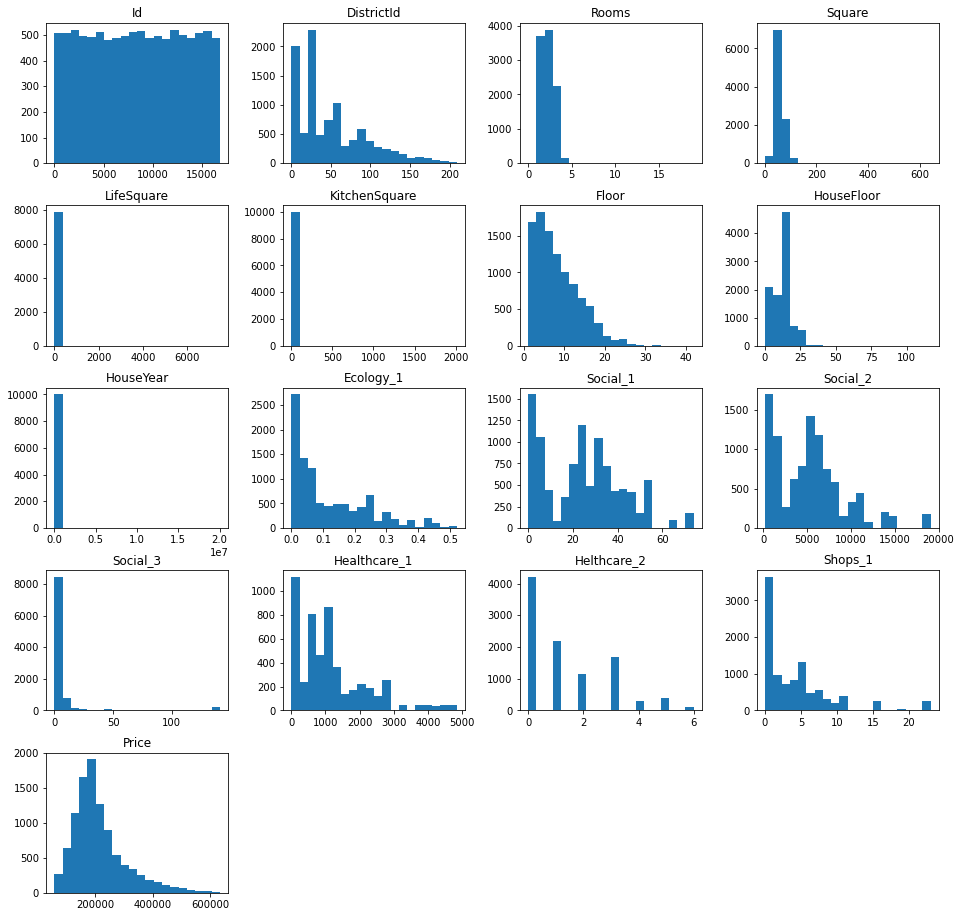

In [27]:
data_df.hist(figsize=(16,16), bins=20, grid=False);

###### ***1. Проанализируем признак 'Rooms'***

In [28]:
# сколько вариантов комнат? 
# сколько вариантов с 0 комнат? 

In [29]:
# сколько вариантов комнат? 
data_df['Rooms'].value_counts()

2.0     3880
1.0     3705
3.0     2235
4.0      150
5.0       18
0.0        8
10.0       2
19.0       1
6.0        1
Name: Rooms, dtype: int64

In [30]:
# создадим новый признак 'Rooms_change' - он будет = 1 в строках, где внесем изменения в значения признака 'Rooms'
data_df['Rooms_change'] = 0
data_df.loc[(data_df['Rooms'] == 0) | (data_df['Rooms'] >= 6), 'Rooms_change'] = 1

In [31]:
data_df.loc[data_df['Rooms'] == 0, 'Rooms'] = 1
data_df.loc[data_df['Rooms'] >= 6, 'Rooms'] = data_df['Rooms'].median()

In [32]:
data_df.loc[(data_df['Rooms_change'] == 1) ]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Rooms_change
2004,5927,57,2.0,59.056975,36.223072,10.0,22,22.0,2002,0.090799,...,B,74,19083,2,NaN,5,15,B,317265.323792,1
2194,3159,88,1.0,38.697117,19.345131,9.0,9,16.0,1982,0.127376,...,B,43,8429,3,NaN,3,9,B,158998.110646,1
2728,14865,9,2.0,60.871266,38.420681,10.0,3,2.0,1994,0.161532,...,B,25,5648,1,30.0,2,4,B,172329.270863,1
3780,7317,27,1.0,41.790881,NaN,0.0,13,0.0,1977,0.211401,...,B,9,1892,0,NaN,0,1,B,98129.976788,1
5894,770,28,1.0,49.483501,NaN,0.0,16,0.0,2015,0.118537,...,B,30,6207,1,1183.0,1,0,B,217009.338463,1
6088,8491,1,2.0,42.006046,21.779288,7.0,17,17.0,2014,0.007122,...,B,1,264,0,NaN,0,1,B,78364.616704,1
6401,9443,27,1.0,87.762616,85.125471,0.0,5,15.0,1977,0.211401,...,B,9,1892,0,NaN,0,1,B,219281.918007,1
7644,7917,27,1.0,212.932361,211.231125,0.0,2,3.0,2008,0.211401,...,B,9,1892,0,NaN,0,1,B,302211.260887,1
7929,456,6,1.0,81.491446,NaN,0.0,4,0.0,1977,0.243205,...,B,5,1564,0,540.0,0,0,B,212864.799112,1
8794,14003,99,2.0,59.414334,38.702244,6.0,7,9.0,1969,0.033494,...,B,66,10573,1,1322.0,3,8,B,229661.964416,1


In [33]:
# сколько вариантов комнат после упрощения? 
data_df['Rooms'].value_counts()

2.0    3884
1.0    3713
3.0    2235
4.0     150
5.0      18
Name: Rooms, dtype: int64

###### ***2. Проанализируем признаки, касающиеся площадей:  KitchenSquare, Square, LifeSquare***

In [34]:
# Проанализируем:
# сколько пропусков в признаках?
# сколько объектов с кухнями больше, чеу у 99,5% объектов?
# сколько объектов с кухнями меньша 4м2?
# сколько объектов с площадью Square менее 20?
# сколько объектов с площадью Square меньше LifeSquare? Поменяем местами, если Square меньше LifeSquare
# Заменим эти значения на медианы (и добавим новые признаки, указывающие на эту замену)
# Заменим пропуски в LifeSquare (+ создадим признак учета замен LifeSquare_nan)

In [35]:
data_df.isna().sum()

Id                  0
DistrictId          0
Rooms               0
Square              0
LifeSquare       2113
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1     4798
Helthcare_2         0
Shops_1             0
Shops_2             0
Price               0
Rooms_change        0
dtype: int64

In [36]:
data_df.select_dtypes(include='object').columns.tolist()

['Ecology_2', 'Ecology_3', 'Shops_2']

In [37]:
kitchen_square_quantile = data_df['KitchenSquare'].quantile(.995)
kitchen_square_quantile

20.0

In [38]:
data_df.loc[data_df['KitchenSquare'] > 20, 'KitchenSquare'].count()

48

In [39]:
# заменим медианой и значением 4
condition = (data_df['KitchenSquare'].isna()) | (data_df['KitchenSquare'] > kitchen_square_quantile)
data_df.loc[condition, 'KitchenSquare'] = data_df['KitchenSquare'].median()
data_df.loc[data_df['KitchenSquare'] < 4, 'KitchenSquare'] = 4

In [40]:
# сколько объектов с площадью Square менее 20?
data_df.loc[data_df['Square'] < 20, 'Square'].count()

21

In [41]:
# сколько объектов с площадью Square меньше LifeSquare?
data_df.loc[data_df['Square'] < data_df['LifeSquare'], 'Square'].count()

482

In [42]:
data_df['Square_min'] = 0
data_df.loc[data_df['Square'] < 20, 'Square_min']  = 1
data_df.loc[data_df['Square'] < 20, 'Square']  = data_df['Square'].median()

In [43]:
# Поменяем значения Square и LifeSquare, если одно больше другого
data_df['Square'], data_df['LifeSquare'] = np.where(data_df['Square'] < data_df['LifeSquare'],\
                                (data_df['LifeSquare'],data_df['Square']), (data_df['Square'],data_df['LifeSquare']))

In [44]:
# Заменим пропуски в LifeSquare (+ создадим признак учета замен LifeSquare_nan)
data_df['LifeSquare_nan'] = 0
data_df.loc[data_df['LifeSquare'].isna(), 'LifeSquare_nan'] = 1 
data_df.loc[data_df['LifeSquare'].isna(), 'LifeSquare'] = data_df['LifeSquare'].median() 

###### ***3. Проанализируем признаки 'HouseFloor, Floor'***

In [45]:
# Проанализируем:
# сколько объектов с HouseFloor = 0 ? (заменим на 1)
# сколько объектов с HouseFloor меньше Floor? (поменяем местами)
# сколько объектов с HouseFloor > 50 (заменим на медиану) 


In [46]:
# сколько объектов с HouseFloor = 0 ?
data_df.loc[data_df['HouseFloor'] == 0, 'HouseFloor'].count()

269

In [47]:
# (заменим на 1)
# заменим 0 в HouseFloor на медиану. Введем новй признак HouseFloor_0
data_df['HouseFloor_0'] = 0
data_df.loc[data_df['HouseFloor'] == 0, 'HouseFloor_0'] = 1
data_df.loc[data_df['HouseFloor'] == 0, 'HouseFloor'] = data_df['HouseFloor'].median()

In [48]:
# сколько объектов с HouseFloor меньше Floor?
data_df.loc[data_df['Floor'] > data_df['HouseFloor'], 'HouseFloor'].count()

1610

In [49]:
### поменяем Floor и HouseFloor местами (где Floor > HouseFloor) + новый признак HouseFloor_change
data_df['HouseFloor_change'] = 0
data_df.loc[data_df['Floor'] > data_df['HouseFloor'], 'HouseFloor_change'] = 1
data_df['Floor'], data_df['HouseFloor'] = np.where(data_df['Floor'] < data_df['HouseFloor'],\
                                (data_df['Floor'],data_df['HouseFloor']), (data_df['HouseFloor'],data_df['Floor']))


In [50]:
# сколько объектов с HouseFloor > 50 ?
data_df.loc[data_df['HouseFloor'] > 50, 'HouseFloor'].count()

3

In [51]:
# сколько объектов с HouseFloor > 50 (заменим на медиану) 
data_df['HouseFloor_veryhight'] = 0
data_df.loc[data_df['HouseFloor'] > 50, 'HouseFloor_veryhight' ] = 1
data_df.loc[data_df['HouseFloor'] > 50, 'HouseFloor'] = data_df['HouseFloor'].median()

In [52]:
# посмотрим на замену
data_df.loc[data_df['HouseFloor_change'] == 1 ]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Helthcare_2,Shops_1,Shops_2,Price,Rooms_change,Square_min,LifeSquare_nan,HouseFloor_0,HouseFloor_change,HouseFloor_veryhight
17,1190,8,2.0,49.396000,28.299600,5.0,5.0,6.0,1962,0.458174,...,1,5,B,186971.926566,0,0,0,0,1,0
19,367,45,1.0,42.367289,40.012529,4.0,14.0,16.0,2015,0.195781,...,3,2,B,250466.980777,0,0,0,0,1,0
21,8471,20,3.0,75.611065,47.494621,8.0,9.0,11.0,1976,0.019509,...,5,5,B,366916.246494,0,0,0,0,1,0
25,4521,6,2.0,65.409965,32.772431,4.0,1.0,18.0,1977,0.243205,...,0,0,B,191205.272608,0,0,1,0,1,0
26,8553,88,3.0,83.262530,4.769174,4.0,1.0,13.0,1977,0.127376,...,3,9,B,410883.892020,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9953,7659,57,1.0,38.485252,22.550608,8.0,17.0,19.0,1992,0.133215,...,3,4,A,183485.284995,0,0,0,0,1,0
9960,16258,48,3.0,98.152802,96.056784,4.0,1.0,15.0,2017,0.041125,...,1,10,B,524365.550705,0,0,0,0,1,0
9968,9920,1,3.0,86.487550,32.772431,4.0,17.0,18.0,1977,0.007122,...,0,1,B,248248.935528,0,0,1,0,1,0
9970,13501,6,1.0,41.310416,19.117077,9.0,17.0,18.0,1977,0.243205,...,0,0,B,114878.830713,0,0,0,0,1,0


###### ***4. Проанализируем признак 'HouseYear'***

In [53]:
# сколько объектов с кодом  больше текущего ? (заменим на текущий)


In [54]:
data_df.loc[data_df['HouseYear'] > datetime.now().year, 'HouseYear'].count()

2

In [55]:
# год больше текущего заменим на текущий
data_df.loc[data_df['HouseYear'] > datetime.now().year, 'HouseYear'] = datetime.now().year

###### ***5. Проанализируем признак 'Healthcare_1 '***

In [56]:
# количество пропусков Healthcare_1? (Заменим медианой)

In [57]:
# количество пропусков Healthcare_1?
data_df.loc[data_df['Healthcare_1'].isna(), 'Id'].count()

4798

In [58]:
 data_df.loc[(data_df['Healthcare_1'].isna()), 'Healthcare_1'] = data_df['Healthcare_1'].median()

In [59]:
# пропусков больше нет
data_df.Healthcare_1.isna().sum()

0

##### 3.2.2. Категориальные признаки

In [60]:
# какие признаки категориальные ?
# Какие значения они принимают?
#
#
#

In [61]:
# какие признаки категориальные ?
data_df.select_dtypes(include='object').columns.tolist()

['Ecology_2', 'Ecology_3', 'Shops_2']

In [62]:
# Какие значения они принимают?
print(data_df.Ecology_2.value_counts())
print(data_df.Ecology_3.value_counts())
print(data_df.Shops_2.value_counts())

B    9903
A      97
Name: Ecology_2, dtype: int64
B    9725
A     275
Name: Ecology_3, dtype: int64
B    9175
A     825
Name: Shops_2, dtype: int64


In [63]:
# заменим на бинарные

binary_to_numbers = {'A': 0, 'B': 1}
data_df['Ecology_2'] = data_df['Ecology_2'].replace(binary_to_numbers)
data_df['Ecology_3'] = data_df['Ecology_3'].replace(binary_to_numbers)
data_df['Shops_2'] = data_df['Shops_2'].replace(binary_to_numbers)

In [64]:
# для дальнейшего использования признак DistrictId переведем в обжект
data_df['DistrictId'] = data_df['DistrictId'].astype(object)

### 4. Предобработка данных   <a id='section_id_4'></a>
([назад к  меню](#section_id_0))

<font color=green>
    
**Идеи по предобработке:**<br>
Общие идеи: убрать выбросы, заменить пропущенные значения в признаках на новые значения. На какие значения менять - попробуем проэкспериментировать.

1. Комнаты (Rooms) 
    - в квартирах, где комнат больше 6, заменить это значение на среднее 
    - добавить новый признак (Rooms_change), отражающий эти изменения в признаке Rooms
    
    
2. Площади (KitchenSquare) 
    - в объектах, где площать кухни KitchenSquare пропущена или больше, чем у 99,5 % других объектов  - заменить на медиану по признаку (трейновской выборки)
    - в объектах, где площать кухни KitchenSquare меньше, чем 4м2 - заменить на 4м2
    
    
3. Этажность (HouseFloor)
    - нулевые значения HouseFloor заменить на медиану.
    - добавить новый признак (HouseFloor_0), отражающий эти замены в признаке HouseFloor
    - если этажей больше чем 50, то заменить на медиану.
    - добавить новый признак (HouseFloor_veryhight), отражающий эти замены в признаке HouseFloor
    - если Floor < HouseFloor - поменяем Floor и HouseFloor местами
    - в квартирах, где "Floor" меньше "HouseFloor" поменять местами эти значения 
    - HouseFloor не может быть выше 75 этажей (все что выше - меняем на медиану)    
    
    
4. Год постройки дома (HouseYear)
    - если год постройки дома больше текущей даты, то заменить на текущий год.
    - добавить новый признак (HouseYear_outlier), отражающий эти замены в признаке HouseYear
    
    
5. Здоровье_медицина (Healthcare_1)    
    - пропуски в признаке Healthcare_1 заменим медианой, определенной внутри объектов этого же района


6. Этажность (Square и LifeSquare)
    - значения Square меньше 20м заменить на медиану.
    - добавим новый признак (Square_min), отражающий эти замены в признаке Square    
    - Поменяем значения Square и LifeSquare, если одно больше другого
    - пропуски в LifeSquare заменим на медиану
    - добавим новый признак (LifeSquare_nan), отражающий эти замены в признаке LifeSquare
 

**Реализуем обработку в классе DataPreprocessing**

In [65]:
class DataPreprocessing:
    """Подготовка исходных данных"""

    def __init__(self):
        """Параметры класса"""
        self.medians = None
        self.kitchen_square_quantile = None
        self.districts_healthcare = None
        
        
    def fit(self, DF):
        """Сохранение статистик"""       
        # Расчет медиан
        self.medians = DF.median()
        self.kitchen_square_quantile = DF['KitchenSquare'].quantile(.995)
        self.districts_healthcare = DF.groupby(['DistrictId'])['Healthcare_1'].agg('mean').to_dict()        
    
    def transform(self, DF):
        """Трансформация данных"""

        # Rooms ~ Rooms_change
        DF['Rooms_change'] = 0
        DF.loc[(DF['Rooms'] == 0) | (DF['Rooms'] >= 6), 'Rooms_change'] = 1
        
        DF.loc[DF['Rooms'] == 0, 'Rooms'] = 1
        DF.loc[DF['Rooms'] >= 6, 'Rooms'] = self.medians['Rooms']
        
        # KitchenSquare
        condition = (DF['KitchenSquare'].isna()) \
                    | (DF['KitchenSquare'] > self.kitchen_square_quantile)
        
        DF.loc[condition, 'KitchenSquare'] = self.medians['KitchenSquare']

        DF.loc[DF['KitchenSquare'] < 4, 'KitchenSquare'] = 4
        
        # HouseFloor, Floor
        # заменим 0 в HouseFloor на медиану
        DF['HouseFloor_0'] = 0
        DF.loc[DF['HouseFloor'] == 0, 'HouseFloor_0'] = 1
        DF.loc[DF['HouseFloor'] == 0, 'HouseFloor'] = self.medians['HouseFloor']

        # поменяем Floor и HouseFloor местами (где Floor < HouseFloor)
        DF['HouseFloor_change'] = 0
        DF.loc[DF['Floor'] > DF['HouseFloor'], 'HouseFloor_change'] = 1
        df_HouseFloor = DF.loc[DF['Floor'] > DF['HouseFloor'], 'HouseFloor'] 
        df_Floor = DF.loc[DF['Floor'] > DF['HouseFloor'], 'Floor'] 
        DF.loc[DF['HouseFloor_change'] == 1, 'HouseFloor'] = df_Floor
        DF.loc[DF['HouseFloor_change'] == 1, 'Floor'] = df_HouseFloor        

        # этажей больше чем 50
        DF['HouseFloor_veryhight'] = 0
        DF.loc[DF['HouseFloor'] > 50, 'HouseFloor_veryhight' ] = 1
        DF.loc[DF['HouseFloor'] > 50, 'HouseFloor'] = self.medians['HouseFloor']
        
        # HouseYear
        current_year = datetime.now().year
        DF['HouseYear_outlier'] = 0
        DF.loc[DF['HouseYear'] > current_year, 'HouseYear_outlier'] = 1
        DF.loc[DF['HouseYear'] > current_year, 'HouseYear'] = current_year
        
        # Healthcare_1
        DF.loc[DF['Healthcare_1'].isna(), 'Healthcare_1'] = DF['DistrictId'].map(self.districts_healthcare)
        DF['Healthcare_1'].fillna(self.medians.Healthcare_1, inplace=True)       
        # Clip on upper quantille
        q_max = np.quantile(DF['Healthcare_1'], q=0.9)
        DF['Healthcare_1'].clip(upper=q_max, axis=0, inplace=True)           
            
        #     Square
        DF['Square_min'] = 0
        DF.loc[DF['Square'] < 20, 'Square_min']  = 1
        DF.loc[DF['Square'] < 20, 'Square']  = self.medians['Square']

        # Поменяем значения Square и LifeSquare, если одно больше другого
        DF['Square'], DF['LifeSquare'] = np.where(DF['Square'] < DF['LifeSquare'],\
                                (DF['LifeSquare'],DF['Square']), (DF['Square'],DF['LifeSquare']))
        
       
        # LifeSquare  
        DF['LifeSquare_nan'] = 0
        DF.loc[DF['LifeSquare'].isna(), 'LifeSquare_nan'] = 1 
        DF.loc[DF['LifeSquare'].isna(), 'LifeSquare'] = self.medians['LifeSquare']  
    
   
         
        DF.fillna(self.medians, inplace=True)
        
        return DF

<font color=green>
    
**Создадим новые признаки:**
  

1. Признак района (DistrictId)
    - номер DistrictId свяжем с количеством объектов в этом районе
    
    
2. Новый признак (MedPriceByDistrict)
    - Построим зависимость стоимости квартиры от количества комнат и от района, в котором она находится.
    
    
3. Новый признак (MedPriceByFloorYear)
    - Построим зависимость стоимости квартиры от этажа и года постройки дома.


4. Новый признак (MedPriceStalinka)
    - Построим зависимость стоимости квартиры от типа дома (ЭТАЖНОСТЬ и год постройки: "сталинки", "хрущевки" и т.д.).


5. Новый признак (MedPrice_District_Health)
    - Построим зависимость стоимости квартиры от обеспеченности района медучреждениями (признаки Healthcare).
    
    
6. Новый признак (MedPrice_District_socia)
    - Построим зависимость стоимости квартиры от обеспеченности района объектами соцкультбыта (признаки Social).    


7. Новый признак (MedPrice_District_Shop_1)
    - Построим зависимость стоимости квартиры от обеспеченности района магазинами (признаки Shop)
    

**Реализуем создание новых признаков в классе FeatureGenerator**

In [66]:
class FeatureGenerator():
    """Генерация новых фич"""
    
    def __init__(self):
        self.DistrictId_counts = None
        self.binary_to_numbers = None
        self.med_price_by_district = None
        self.med_price_by_floor_year = None
        self.house_year_max = None
        self.floor_max = None
        self.district_size = None
        self.med_price_by_housefloor_year = None # для сталинок
        self.med_price_by_district_health = None # для здоровья        
        self.med_price_by_district_social = None # для social 
        self.med_price_by_district_shop = None # для shop         
        
        
    def fit(self, X, y=None):
        
        X = X.copy()
        
        # Binary features
        self.binary_to_numbers = {'A': 0, 'B': 1}
        
        # DistrictID
        self.district_size = X['DistrictId'].value_counts().reset_index() \
                               .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})
        

                
        # Target encoding
        ## District, Rooms
        df = X.copy()
        
        if y is not None:
            df['Price'] = y.values
            
            self.med_price_by_district = df.groupby(['DistrictId', 'Rooms'], as_index=False).agg({'Price':'median'})\
                                            .rename(columns={'Price':'MedPriceByDistrict'})
            
            self.med_price_by_district_median = self.med_price_by_district['MedPriceByDistrict'].median()
            
        ## floor, year
        if y is not None:
            self.floor_max = df['Floor'].max()
            self.house_year_max = df['HouseYear'].max()
            df['Price'] = y.values
            df = self.floor_to_cat(df)
            df = self.year_to_cat(df)
            self.med_price_by_floor_year = df.groupby(['year_cat', 'floor_cat'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceByFloorYear'})
            self.med_price_by_floor_year_median = self.med_price_by_floor_year['MedPriceByFloorYear'].median()
        
        
        
#    Сталинки 
        ## DistrictId, year
        if y is not None:
            self.floor_max = df['HouseFloor'].max()
            self.house_year_max = df['HouseYear'].max()
            df['Price'] = y.values
            df = self.housefloor_to_cat(df)
            df = self.houseyear_to_cat(df)
            self.med_price_by_housefloor_year = df.groupby(['stalinka_cat', 'housefloor_cat'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceStalinka'})
            self.med_price_by_housefloor_year_median = self.med_price_by_housefloor_year['MedPriceStalinka'].median()

#    Район и здоровье         
        
        ## DistrictId, Healthcare_1
        if y is not None:
            df['Price'] = y.values           
            self.med_price_by_district_health = df.groupby(['DistrictId', 'Healthcare_1'], as_index=False).agg({'Price':'median'})\
                                            .rename(columns={'Price':'MedPrice_District_Health'})
            
            self.med_price_by_district_health_median = self.med_price_by_district_health['MedPrice_District_Health'].median() 

#    Район и социал         
        
        ## DistrictId, Social
        if y is not None:
            df['Price'] = y.values           
            self.med_price_by_district_social = df.groupby(['DistrictId', 'Social_2'], as_index=False).agg({'Price':'median'})\
                                            .rename(columns={'Price':'MedPrice_District_socia'})
            
            self.med_price_by_district_social_median = self.med_price_by_district_social['MedPrice_District_socia'].median() 
        
        
#    Район и Shops_1         
        
        ## DistrictId, Shops_1
        if y is not None:
            df['Price'] = y.values           
            self.med_price_by_district_shop = df.groupby(['DistrictId', 'Shops_1'], as_index=False).agg({'Price':'median'})\
                                            .rename(columns={'Price':'MedPrice_District_Shop_1'})
            
            self.med_price_by_district_shop_median = self.med_price_by_district_shop['MedPrice_District_Shop_1'].median() 
        
        
    def transform(self, X):
        
        # Binary features
        X['Ecology_2'] = X['Ecology_2'].map(self.binary_to_numbers)  # self.binary_to_numbers = {'A': 0, 'B': 1}
        X['Ecology_3'] = X['Ecology_3'].map(self.binary_to_numbers)
        X['Shops_2'] = X['Shops_2'].map(self.binary_to_numbers)
        
        # DistrictId, IsDistrictLarge
        X = X.merge(self.district_size, on='DistrictId', how='left')
        
        X['new_district'] = 0
        X.loc[X['DistrictSize'].isna(), 'new_district'] = 1
        
        X['DistrictSize'].fillna(5, inplace=True)
        
        X['IsDistrictLarge'] = (X['DistrictSize'] > 100).astype(int)
        
        # More categorical features
        X = self.floor_to_cat(X)  # + столбец floor_cat
        X = self.year_to_cat(X)   # + столбец year_cat
        
        ############################    Сталинки 
        X = self.housefloor_to_cat(X)   # + столбец housefloor_to_cat для сталинок
        X = self.houseyear_to_cat(X)   # + houseyear_to_cat для сталинок

        
        # Target encoding
        if self.med_price_by_district is not None:
            X = X.merge(self.med_price_by_district, on=['DistrictId', 'Rooms'], how='left')
            X['MedPriceByDistrict'].fillna(self.med_price_by_district_median, inplace=True)
            
        if self.med_price_by_floor_year is not None:
            X = X.merge(self.med_price_by_floor_year, on=['year_cat', 'floor_cat'], how='left')
            X['MedPriceByFloorYear'].fillna(self.med_price_by_floor_year_median, inplace=True)
            
            
#    Сталинки    
        if self.med_price_by_housefloor_year is not None:
            X = X.merge(self.med_price_by_housefloor_year, on=['stalinka_cat', 'housefloor_cat'], how='left')
            X['MedPriceStalinka'].fillna(self.med_price_by_housefloor_year_median, inplace=True)
                
#    Health  
        if self.med_price_by_district_health is not None:
            X = X.merge(self.med_price_by_district_health, on=['DistrictId', 'Healthcare_1'], how='left')
            X['MedPrice_District_Health'].fillna(self.med_price_by_district_health_median, inplace=True)

#    Social  
        if self.med_price_by_district_social is not None:
            X = X.merge(self.med_price_by_district_social, on=['DistrictId', 'Social_2'], how='left')
            X['MedPrice_District_socia'].fillna(self.med_price_by_district_social_median, inplace=True)

#    Shops  
        if self.med_price_by_district_shop is not None:
            X = X.merge(self.med_price_by_district_shop, on=['DistrictId', 'Shops_1'], how='left')
            X['MedPrice_District_Shop_1'].fillna(self.med_price_by_district_shop_median, inplace=True)

        
        return X
    
    def floor_to_cat(self, X):
        bins = [0, 3, 5, 9, 15, self.floor_max]
        X['floor_cat'] = pd.cut(X['Floor'], bins=bins, labels=False)#
        X['floor_cat'].fillna(-1, inplace=True)
        return X
     
    def year_to_cat(self, X):
        bins = [0, 1941, 1945, 1980, 2000, 2010, self.house_year_max]
        X['year_cat'] = pd.cut(X['HouseYear'], bins=bins, labels=False)#
        X['year_cat'].fillna(-1, inplace=True)
        return X
            
# Сталинки
    def housefloor_to_cat(self, X):
        bins = [1,2,3,4,5,9, self.floor_max]

        X['housefloor_cat'] = pd.cut(X['HouseFloor'], bins=bins, labels=False)
        
        X['housefloor_cat'].fillna(-1, inplace=True)
        return X    
    
   
    def houseyear_to_cat(self, X):
        bins = [1933, 1957, 1985]
        X['stalinka_cat'] = pd.cut(X['HouseYear'], bins=bins, labels=False)

        X['stalinka_cat'].fillna(-1, inplace=True)
        return X


<font color=green>
В результате предобработки имеем станые (исходные) и новые (придуманные признаки).<br>
Для более удобного "включения" - "отключения" этих признаков при поиске оптимального решения, выведем 
их в отдельные переменные.<br>
    
Будем работать с переменными **feature_names** и **new_feature_names**.<br>
    
В результате подбора оптимального решения был выбран определенный набор признаков, включеный в итоговую модель (остальнве закомментированы)

In [67]:
feature_names = ['Rooms', 
                 'Square', 'LifeSquare', 'KitchenSquare',
                 'Floor', 
                 'HouseFloor',
                 'HouseYear',
                 'Ecology_1', 
                 #'Ecology_2',
                 #'Ecology_3', 
                 'Social_1',
                 'Social_2',
                 'Social_3', 
                 'Healthcare_1',
                # 'Helthcare_2',
                 'Shops_1' ,
                 #'Shops_2'
                ]

new_feature_names = ['Rooms_change', 
                     #'HouseFloor_change', ####
                     #'HouseFloor_0'   ###
                     #'HouseYear_outlier', 
                    # 'Square_min',
                     'LifeSquare_nan', 
                     'DistrictSize',
                    # 'new_district', 
                     #'IsDistrictLarge',  
                     #'MedPriceByDistrict', 
                     #'MedPriceByFloorYear', 
                     'MedPriceStalinka', 
                     'MedPrice_District_Health',
                     #'MedPrice_District_socia',
                     #'HouseFloor_veryhight',
                    # 'MedPrice_District_Shop_1'#,
                     #'Social'
                    # 'Shops'
                    ]


In [68]:
target_name = 'Price'

### 5.   <a id='section_id_5'></a>Обучение и валидация моделей 
([назад к  меню](#section_id_0))

<font color=green>
Предварительные подготовки завершены.<br>
Запускаем создание моделей.<br>
Разобъем выборки на "обучение" и "валидацию"

In [69]:
train_df = pd.read_csv(TRAIN_PATH)
test_df = pd.read_csv(TEST_PATH)

In [70]:
X = train_df.drop(columns=target_name)
y = train_df[target_name]

In [71]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=21)

In [72]:
# произведем предобработку X_train
preprocessor = DataPreprocessing()
preprocessor.fit(X_train)

In [73]:
X_train = preprocessor.transform(X_train)

In [74]:
# произведем предобработку X_valid и test_df
X_valid = preprocessor.transform(X_valid)
test_df = preprocessor.transform(test_df)

X_train.shape, X_valid.shape, test_df.shape

((8000, 26), (2000, 26), (5000, 26))

In [75]:
# создадим новые признаки
features_gen = FeatureGenerator()
features_gen.fit(X_train, y_train)

X_train = features_gen.transform(X_train)
X_valid = features_gen.transform(X_valid)
test_df = features_gen.transform(test_df)

X_train.shape, X_valid.shape, test_df.shape

((8000, 39), (2000, 39), (5000, 39))

In [76]:
# включим в датафреймы X_train, X_valid, test_df набор признаков, который считаем оптимальным
X_train = X_train[feature_names + new_feature_names]
X_valid = X_valid[feature_names + new_feature_names]
test_df = test_df[feature_names + new_feature_names]

In [77]:
# обучим модель линейной регрессии и случайного леса
LR_model.fit(X_train, y_train)
RF_model.fit(X_train, y_train)


RandomForestRegressor()

In [78]:
# создадим модель градиентного бустинга
# Этап настройки параметров модели с помощью KFold, GridSearchCV пропущен (закомментирован)

GB_model = GradientBoostingRegressor(criterion='mse',
                                     max_depth=6,
                                     min_samples_leaf=50,
                                     random_state=42,  
                                     n_estimators=2250, 
                                     max_features='sqrt', 
                                     loss='huber', 
                                     learning_rate=0.025)



In [79]:
#  создадим XGB_model
# Этап настройки параметров модели с помощью KFold, GridSearchCV пропущен (закомментирован)
import xgboost as xgb
from xgboost.sklearn import XGBRegressor

# старые неплохие параметры
xgb_model = xgb.XGBRegressor(colsample_bytree=0.29, 
                              learning_rate=0.015, max_depth=8,
                              min_child_weight=0.1, 
                              n_estimators=1000,
                              reg_lambda=0.7,
                              random_state =7)


In [80]:
#  создадим LGB_model
# Этап настройки параметров модели с помощью KFold, GridSearchCV пропущен (закомментирован)
import lightgbm as lgb
from lightgbm.sklearn import LGBMRegressor

lgb_model = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)


In [81]:
#  ОБУЧИМ МОДЕЛИ

#обучим LR
LR_model.fit(X_train, y_train)
#обучим RF
RF_model.fit(X_train, y_train)
#обучим GB
GB_model.fit(X_train, y_train)
#обучим XGB
xgb_model.fit(X_train, y_train)
#обучим LGB
lgb_model.fit(X_train, y_train)


[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


LGBMRegressor(bagging_fraction=0.8, bagging_freq=5, bagging_seed=9,
              feature_fraction=0.2319, feature_fraction_seed=9,
              learning_rate=0.05, max_bin=55, min_data_in_leaf=6,
              min_sum_hessian_in_leaf=11, n_estimators=720, num_leaves=5,
              objective='regression')

In [82]:
# посчитаем целевую функцию на различных моделях (для обучени и для теста)

LR_predict = LR_model.predict(X_valid)
LR_predict_train = LR_model.predict(X_train)

RF_predict = RF_model.predict(X_valid)
RF_predict_train = RF_model.predict(X_train)

GB_predict = GB_model.predict(X_valid)
GB_predict_train = GB_model.predict(X_train)

XGB_predict = xgb_model.predict(X_valid)
XGB_predict_train = xgb_model.predict(X_train)

LGB_predict = lgb_model.predict(X_valid)
LGB_predict_train = lgb_model.predict(X_train)

In [83]:
# посчитаем метрики
from sklearn.metrics import r2_score

r2_LR = round(r2_score(y_valid, LR_predict),4)
r2_LR_tr = round(r2_score(y_train, LR_predict_train),4)

r2_RF = round(r2_score(y_valid, RF_predict),4)
r2_RF_tr = round(r2_score(y_train, RF_predict_train),4)

r2_GB = round(r2_score(y_valid, GB_predict),4)
r2_GB_tr = round(r2_score(y_train, GB_predict_train),4)

r2_XGB = round(r2_score(y_valid, XGB_predict),4)
r2_XGB_tr = round(r2_score(y_train, XGB_predict_train),4)

r2_LGB = round(r2_score(y_valid, LGB_predict),4)
r2_LGB_tr = round(r2_score(y_train, LGB_predict_train),4)



In [84]:
# выведем метрики метрики
print(f'Для линейной регрессии \t\tr2 TEST = {r2_LR} TRAIN= {r2_LR_tr}')
print(f'Для случайного леса \t\tr2 TEST = {r2_RF} TRAIN= {r2_RF_tr}')
print(f'Для градиентного бустинга \tr2 TEST = {r2_GB} TRAIN= {r2_GB_tr}')
print(f'Для XGB \t\t\tr2 TEST = {r2_XGB} TRAIN= {r2_XGB_tr}')
print(f'Для LGB \t\t\tr2 TEST = {r2_LGB} TRAIN= {r2_LGB_tr}')

Для линейной регрессии 		r2 TEST = -2.2352 TRAIN= 0.6524
Для случайного леса 		r2 TEST = 0.747 TRAIN= 0.9629
Для градиентного бустинга 	r2 TEST = 0.7773 TRAIN= 0.864
Для XGB 			r2 TEST = 0.779 TRAIN= 0.9561
Для LGB 			r2 TEST = 0.7512 TRAIN= 0.7933


In [85]:
# посмотрим на кроссвалидации
cv_score = cross_val_score(lgb_model, X_train, y_train, scoring='r2', cv=KFold(n_splits=5, shuffle=True, random_state=21))
cv_score

[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11

array([0.74403348, 0.72854674, 0.70375448, 0.76789918, 0.74432803])

In [86]:
cv_score.mean()

0.7377123805683258

In [87]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor 
from xgboost.sklearn import XGBRegressor
from lightgbm.sklearn import LGBMRegressor
from sklearn import linear_model, ensemble
import xgboost as xgb
import lightgbm as lgb
import catboost as ctb

In [88]:

from sklearn.ensemble import StackingRegressor

lr = LinearRegression()
rf = RandomForestRegressor()
gb = GradientBoostingRegressor()
xgb = xgb.XGBRegressor()
lgb = lgb.LGBMRegressor()

stack = StackingRegressor([('rf', RF_model), ('gb', GB_model),  ('xgb', xgb_model), ('lgb', lgb_model)], final_estimator=lr)
stack.fit(X_train, y_train)


[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11

StackingRegressor(estimators=[('rf', RandomForestRegressor()),
                              ('gb',
                               GradientBoostingRegressor(criterion='mse',
                                                         learning_rate=0.025,
                                                         loss='huber',
                                                         max_depth=6,
                                                         max_features='sqrt',
                                                         min_samples_leaf=50,
                                                         n_estimators=2250,
                                                         random_state=42)),
                              ('xgb',
                               XGBRegressor(base_score=0.5, booster='gbtree',
                                            colsample_bylevel=1,
                                            colsample_bynode=1,
                                            colsample_

In [89]:
stack_predict = stack.predict(X_valid)
stack_predict_train = stack.predict(X_train)

In [90]:
r2_stack = round(r2_score(y_valid, stack_predict),4)
r2_stack_tr = round(r2_score(y_train, stack_predict_train),4)

In [91]:
print(f'Для линейной регрессии \t\tr2 TEST = {r2_LR} TRAIN= {r2_LR_tr}')
print(f'Для случайного леса \t\tr2 TEST = {r2_RF} TRAIN= {r2_RF_tr}')
print(f'Для градиентного бустинга \tr2 TEST = {r2_GB} TRAIN= {r2_GB_tr}')
print(f'Для XGB \t\t\tr2 TEST = {r2_XGB} TRAIN= {r2_XGB_tr}')
print(f'Для LGB \t\t\tr2 TEST = {r2_LGB} TRAIN= {r2_LGB_tr}')
print(f'Для stack \t\t\tr2 TEST = {r2_stack} TRAIN= {r2_stack_tr}')

Для линейной регрессии 		r2 TEST = -2.2352 TRAIN= 0.6524
Для случайного леса 		r2 TEST = 0.747 TRAIN= 0.9629
Для градиентного бустинга 	r2 TEST = 0.7773 TRAIN= 0.864
Для XGB 			r2 TEST = 0.779 TRAIN= 0.9561
Для LGB 			r2 TEST = 0.7512 TRAIN= 0.7933
Для stack 			r2 TEST = 0.7823 TRAIN= 0.909


**Важность признаков**

In [92]:
# важность признаков оцениваем по их весу
feature_importances = pd.DataFrame(zip(X_train.columns, xgb_model.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False)

,feature_name,importance
0,Rooms,0.195345
17,MedPrice_District_Health,0.155115
1,Square,0.116208
15,DistrictSize,0.074908
9,Social_2,0.072271
10,Social_3,0.054207
2,LifeSquare,0.050642
3,KitchenSquare,0.042466
8,Social_1,0.040567
16,MedPriceStalinka,0.028848


### 6. Воспроизводимость  <a id='section_id_6'></a>
([назад к  меню](#section_id_0))

Для воспроизводимости запишем все параметры модели в файл "libraries.txt"

In [93]:
!pip freeze >> librerys.txt

### 7. Выводы   <a id='section_id_7'></a>
([назад к  меню](#section_id_0))

<font color = blue>
    
В ходе выполнения работ был проанализирван набор данных, предназначенный для прогнозирования стоимости квартиры 
по ряду параметров.
В результате получена модель, дающая предсказание стомости квартиры. <br>
**Для модели StackingRegressor получен результат метрики r2 = 0.782** 

Train R2:	0.909
Test R2:	0.782


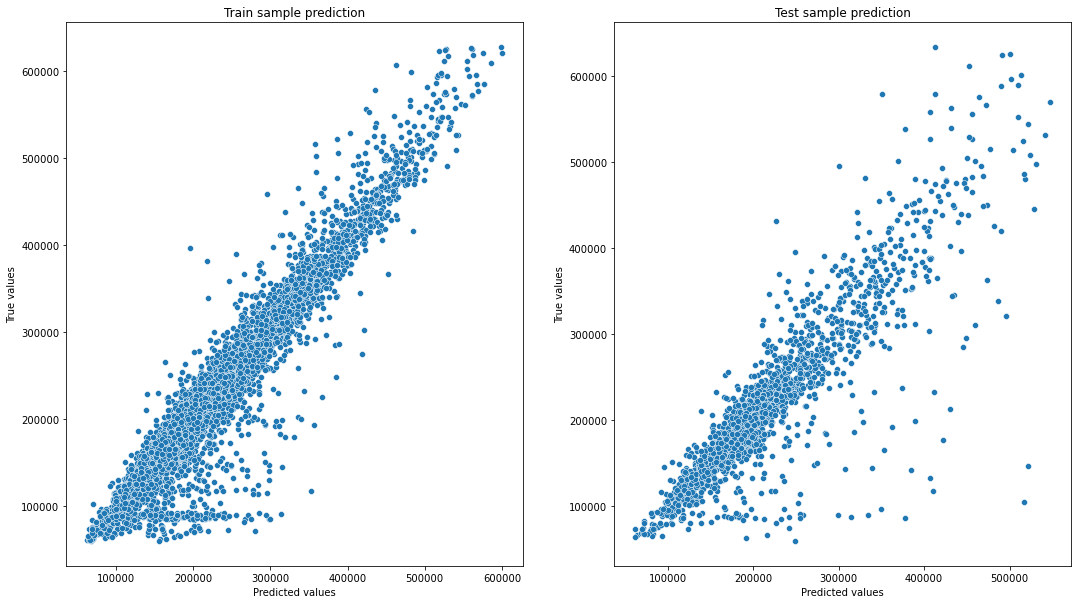

In [94]:
y_train_preds = stack.predict(X_train)
y_test_preds = stack.predict(X_valid)

evaluate_preds(y_train, y_train_preds, y_valid, y_test_preds)

# ВЫВОД ИТОГОВОГО РЕЗУЛЬТАТА ТЕСТА  <a id='section_id_8'></a>
([назад к  меню](#section_id_0))

In [ ]:
# для вывода первоначального решения в КАГГЛ
submit.Price = stack.predict(test_df)


In [ ]:
submit.to_csv('my_stack_tmv.csv', index=False)